## plotNWT_hillslope_simple
#### Plots results from hillslope simulation
- Obs here are flux tower data, included in met forcing data
- Created by Will Wieder, Sept 28, 2021

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import utils
from scipy import signal,stats
import cftime
import nc_time_axis
import dask
#import cf_units as cf

# some resources for plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.pyplot import cm

# supress Runtime warnings that let you know when code isn't too efficiently
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)
from distributed import wait

%matplotlib inline

In [2]:
# Updated for PBS scheduler
# this could go into utils.
# By default gets 1 core w/ 25 GB memory
def get_ClusterClient(ncores=1, nmem='25GB'):
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    ncores=ncores
    nmem = nmem

    cluster = PBSCluster(
        cores=ncores, # The number of cores you want
        memory=nmem, # Amount of memory
        processes=ncores, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
        project='P93300641', # Input your project ID here
        walltime='1:00:00', # Amount of wall time
        interface='ib0', # Interface to use
    )

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })

    client = Client(cluster)
    return cluster, client

In [3]:
cluster, client = get_ClusterClient(nmem='2GB')
cluster.scale(5)

In [4]:
cluster

### Point to files

In [5]:
# Niwot LTER  simulations
# H1 files dimensioned time x column or time x pft
site  = ['MM']
longSite  =  ['moist meadow']#'dry_meadow'
case  =  ['NEON_NIWO_hh_test']
rollHour = -12  
years = range(307,308)
nmon  = 12

#OBSdir = '/glade/p/cgd/tss/people/wwieder/inputdata/single_point/datmdata_NWT_Tvan/'+longSite+'/'
#OBSfile = [OBSdir + str(years[i])+'-'+str(m+1).zfill(2)+'.nc' for i in range(len(years))  for m in range(nmon)]  
#OUTdir = OBSdir
#print(OBSfile)

dirIn = ['/glade/scratch/wwieder/archive/'+case[c]+'/lnd/hist/' for c in range(len(case))]
files = [dirIn[0] + case[0] +'.clm2.h1.0'+str(years[i]) +'-01-01-00000.nc' \
           for i in range(len(years)) ]  
print(files[0])

/glade/scratch/wwieder/archive/NEON_NIWO_hh_test/lnd/hist/NEON_NIWO_hh_test.clm2.h1.0307-01-01-00000.nc


--- 
### Read in dataset 
- get rid of extra dimensions
- remove CLM time shift

In [6]:
%%time
ds = utils.time_set_mid(xr.open_mfdataset(files, decode_times=True, combine='by_coords'), 'time')
print('---- read  in data  ----')

---- read  in data  ----
CPU times: user 650 ms, sys: 125 ms, total: 775 ms
Wall time: 6.7 s


In [7]:
ds#.SNOW_DEPTH

<xarray.Dataset>
Dimensions:             (column: 12, gridcell: 1, hist_interval: 2, landunit: 1, levdcmp: 25, levgrnd: 25, levlak: 10, levsoi: 20, lndgrid: 1, pft: 12, time: 17520)
Coordinates:
  * levgrnd             (levgrnd) float32 0.01 0.04 0.09 ... 19.48 28.87 42.0
  * levsoi              (levsoi) float32 0.01 0.04 0.09 0.16 ... 5.95 6.94 8.03
  * levlak              (levlak) float32 0.05 0.6 2.1 4.6 ... 25.6 34.33 44.78
  * levdcmp             (levdcmp) float32 0.01 0.04 0.09 ... 19.48 28.87 42.0
  * time                (time) object 0306-12-31 23:45:00 ... 0307-12-31 23:1...
Dimensions without coordinates: column, gridcell, hist_interval, landunit, lndgrid, pft
Data variables: (12/82)
    hslp_distance       (column) float64 dask.array<chunksize=(12,), meta=np.ndarray>
    hslp_width          (column) float64 dask.array<chunksize=(12,), meta=np.ndarray>
    hslp_area           (column) float64 dask.array<chunksize=(12,), meta=np.ndarray>
    hslp_elev           (column) float64 dask.array<chunksize=(12,), meta=np.ndarray>
    hslp_slope          (column) float64 dask.array<chunksize=(12,), meta=np.ndarray>
    hslp_aspect         (column) float64 dask.array<chunksize=(12,), meta=np.ndarray>
    ...                  ...
    QDISCHARGE          (time, column) float32 dask.array<chunksize=(17520, 12), meta=np.ndarray>
    QLATFLOWOUT         (time, column) float32 dask.array<chunksize=(17520, 12), meta=np.ndarray>
    SNOW_DEPTH          (time, column) float32 dask.array<chunksize=(17520, 12), meta=np.ndarray>
    SOILC_vr            (time, levsoi, column) float32 dask.array<chunksize=(17520, 20, 12), meta=np.ndarray>
    TBOT                (time, column) float32 dask.array<chunksize=(17520, 12), meta=np.ndarray>
    TSOI                (time, levgrnd, column) float32 dask.array<chunksize=(17520, 25, 12), meta=np.ndarray>
Attributes: (12/101)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              created on 09/24/21 10:25:43
    source:                               Community Terrestrial Systems Model
    hostname:                             cheyenne
    ...                                   ...
    cft_irrigated_tropical_corn:          62
    cft_tropical_soybean:                 63
    cft_irrigated_tropical_soybean:       64
    time_period_freq:                     minute_30
    Time_constant_3Dvars_filename:        ./NEON_NIWO_hh_test.clm2.h0.0208-01.nc
    Time_constant_3Dvars:                 ZSOI:DZSOI:WATSAT:SUCSAT:BSW:HKSAT:...

### Sample surface dataset has 
- 4 aspects [0:2], [3:5], [6:8] & [9:11], which corresponded to `hslp_index` 
- 3 elevation classes low = [0,3,6,9], high = [2,5,8,11]
- all columns have arctic C3 grass
- not sure what `hslp_cold` is about, but it seems to have missing values for the highest elevation columns.  Also, lateral flow is more regular from these columns (see plot below)

In [28]:
print(ds.hslp_aspect.values)
print()
print(ds.hslp_elev.values)
print()
print(ds.pfts1d_itype_veg.values)
print()
print(ds.hslp_cold.values)


[0.         0.         0.         1.57079633 1.57079633 1.57079633
 3.14159265 3.14159265 3.14159265 4.71238898 4.71238898 4.71238898]

[0.83333333 2.5        4.16666667 0.83333333 2.5        4.16666667
 0.83333333 2.5        4.16666667 0.83333333 2.5        4.16666667]

[12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.]

[    2     3 -9999     5     6 -9999     8     9 -9999    11    12 -9999]


In [29]:
ds.hslp_cold


<xarray.DataArray 'hslp_cold' (column: 12)>
dask.array<open_dataset-542c56542ce87516018a55bc86d592behslp_cold, shape=(12,), dtype=int32, chunksize=(12,), chunktype=numpy.ndarray>
Dimensions without coordinates: column
Attributes:
    long_name:  hillslope downhill column index

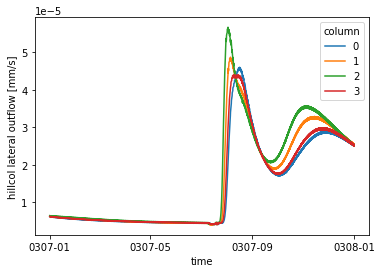

In [30]:
ds.isel(column=[2,5,8,11]).QLATFLOWOUT.plot(hue='column') ;

In [31]:
# patch level variables dimensioned by pft, but also n=12, actually one for each column?
ds.GPP

<xarray.DataArray 'GPP' (time: 17520, pft: 12)>
dask.array<open_dataset-542c56542ce87516018a55bc86d592beGPP, shape=(17520, 12), dtype=float32, chunksize=(17520, 12), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0306-12-31 23:45:00 ... 0307-12-31 23:15:00
Dimensions without coordinates: pft
Attributes:
    long_name:     gross primary production
    units:         gC/m^2/s
    cell_methods:  time: mean

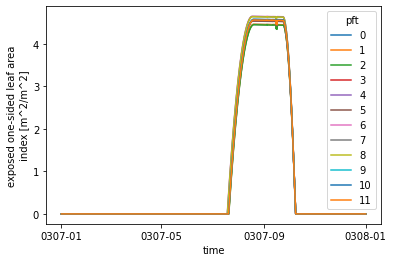

In [32]:
ds.ELAI.plot(hue='pft');

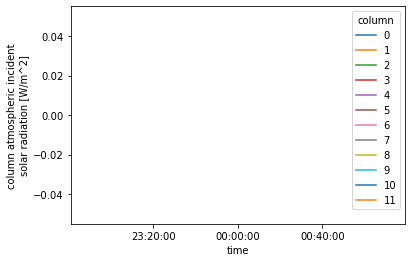

In [40]:
ds.FSDS_COL.plot(hue='column') ;

In [34]:
# Reverse axes here
ds['levsoi'] = ds.levsoi * -1

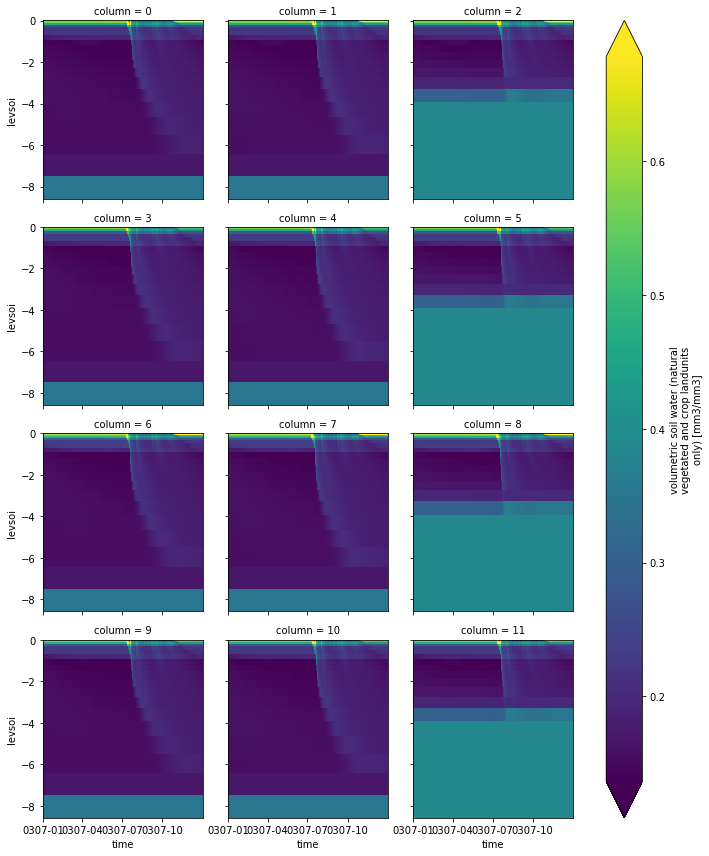

In [38]:
g_simple = ds.H2OSOI.plot(x="time", y="levsoi", col="column", col_wrap=3, robust=True)

In [36]:
ds['levgrnd'] = ds.levgrnd * -1

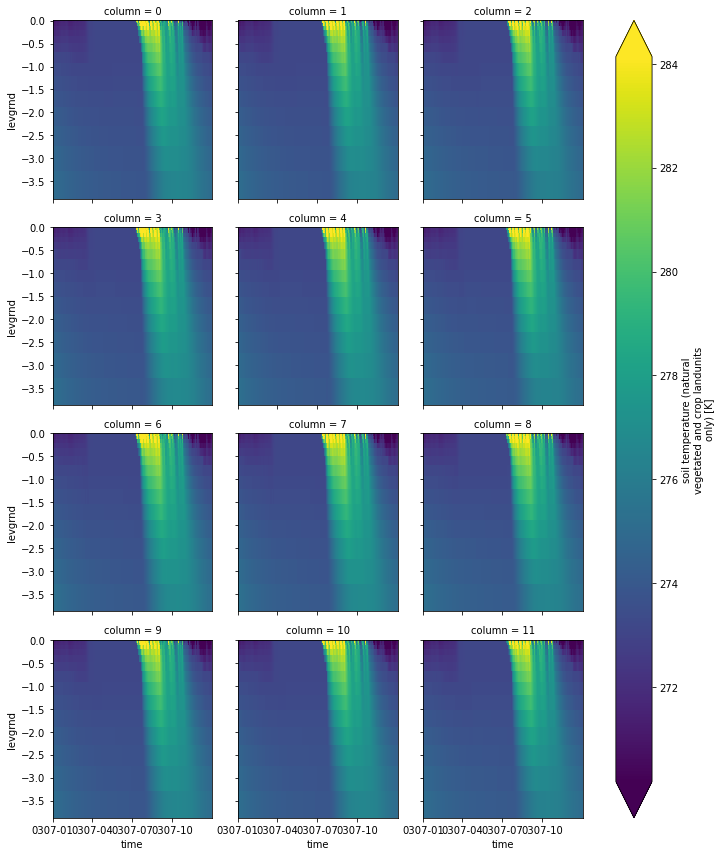

In [39]:
g_simple = ds.isel(levgrnd=slice(0,15)).TSOI.plot(x="time", y="levgrnd", col="column", col_wrap=3, robust=True)